## Version Control/Package Installation Section

In [1]:
#uncomment lines here to install any missing dependencies
#!pip install datasets, transformers, hugginface_hub #hugginface packages
#!pip install numpy, matplotlib, PIL
#!pip install torch torchvision torchaudio #pytorch packages
#ipip install accelerate == 0.28.0 #this specific version is needed to prevent errors

#package versions I use:
#datasets 3.5.0 ; accelerate = 0.28.0 ; transformers = 4.33.3 ; 
#torch = 2.5.1 ; torchvision = 0.20.1; 
#huggingface_hub = 0.30.1 ;
#numpy = 1.25.2 ;
#matplotlib = 3.7.2 ; PIL = 9.5.0 ;

#python version is 3.11.8

In [2]:
#here is just loading in packages
from transformers import AutoModelForImageClassification, AutoImageProcessor, pipeline
import matplotlib.pyplot as plt
import torch
from PIL import Image as PILImage
import os


/Users/robertcf/miniconda3/envs/general/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/Users/robertcf/miniconda3/envs/general/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


# Testing and Using the Bird Classification Model

The purpose of this notebook is to load in the fine tuned bird image classification models I generated for this project and see how it works on new images. It loads in the model from the HuggingFace where the two models, both trained on the same dataset but with different initial models (ViT and Swin). 

In this file images can be run through these models and it will return a prediction of what type of bird it believes that is an image of. I have provided two folders, one with images of birds and one with images of not-birds as examples. 

In [3]:
#Here is where I am loading in the datasets

#Model I trained with ViT general model
pipe_vit = pipeline("image-classification", model = "vit-bird") #loading in my model that should be able to classify birds
image_processor_vit = AutoImageProcessor.from_pretrained("vit-bird") #loading in the image processor
model_vit = AutoModelForImageClassification.from_pretrained("vit-bird") #loading in the model

#Model I trained with Swin general model
pipe_swin = pipeline("image-classification", model = "swin-bird") #loading in my model that should be able to classify birds
image_processor_swin = AutoImageProcessor.from_pretrained("swin-bird") #loading in the image processor
model_swin = AutoModelForImageClassification.from_pretrained("swin-bird") #loading in the model

/Users/robertcf/miniconda3/envs/general/lib/python3.11/site-packages/transformers/modeling_utils.py:488: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(chec

This image_preprocess function must be run on the images you wish to classify. 

In [4]:
def image_preprocess(images, mode = "vit"):
    if mode == "vit": #load in the appropriate image processor for the model you are using
        image_processor = image_processor_vit
    elif mode == "swin":
        image_processor = image_processor_swin
    processed = [] #list to hold the processed images
    # Preprocess the image using the image processor
    for image in images: #process images into tensor format the model can use
        processed.append(image_processor(image.convert("RGB"), return_tensors="pt")) 
    return processed

## Looking at Images of Birds

All images of birds provided here are sourced from the Wikipedia page of that bird

In [5]:
#loading in the images from the folder birds
bird_images = []
bird_folder = "birds" # Path to the folder containing bird images
for filename in os.listdir(bird_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Check for image files
        image = PILImage.open(os.path.join(bird_folder, filename))  # Load the image
        bird_images.append(image)  # Append to the list

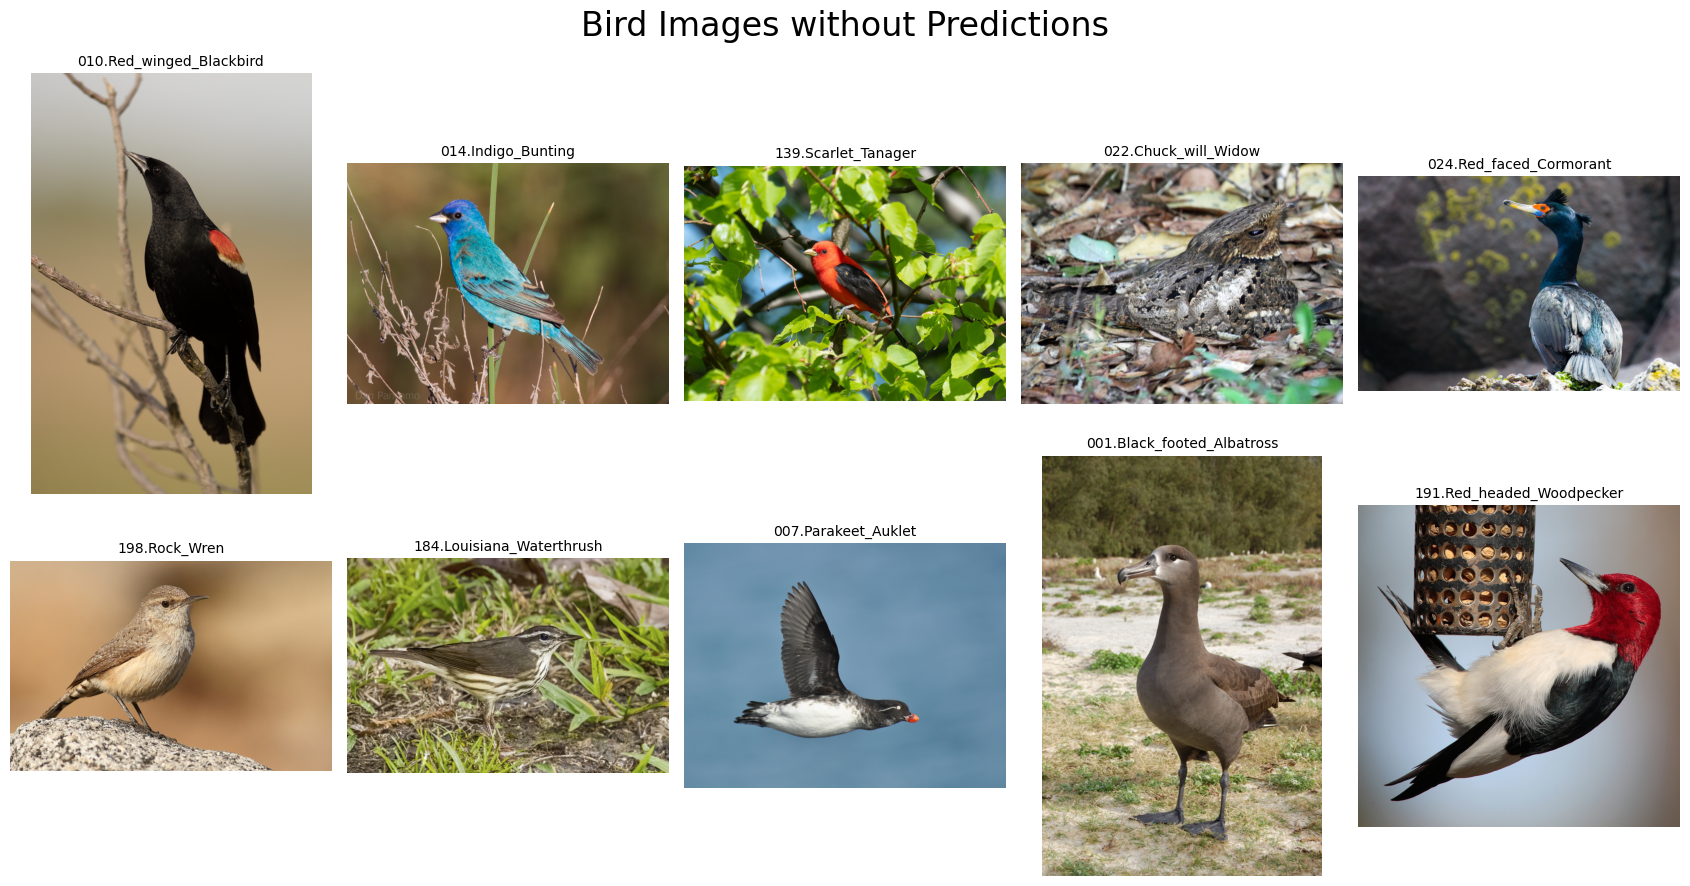

In [6]:
# Set up the grid dimensions
rows, cols = 2, 5  # Adjust based on the number of images
fig, axes = plt.subplots(rows, cols, figsize=(17, 9))

# Loop through the images and display them with filenames
for i, ax in enumerate(axes.flatten()):
    if i < len(bird_images):
        ax.imshow(bird_images[i])
        ax.axis('off')  # Hide axes
        # Add the filename without the extension as a title
        filename_without_extension = os.path.splitext(os.listdir(bird_folder)[i])[0]
        ax.set_title(model_vit.config.id2label[int(filename_without_extension)], fontsize=10)
    else:
        ax.axis('off')  # Hide unused grid cells
fig.suptitle("Bird Images without Predictions", fontsize=24)
plt.tight_layout()
plt.show()

## Generating Predictions

In [7]:
#This is processing the bird images 
encode = image_preprocess(bird_images) #preprocessing the image
print(encode[0].pixel_values.shape) #printing the pixel values

torch.Size([1, 3, 224, 224])


Here is where the predictions are generated, the first part is the predictions with the ViT based model and the second is with the Swin based model.

In [8]:
preds = []
with torch.no_grad():
    for i in range(len(encode)):
        outputs = model_vit(**encode[i]) #getting the outputs from the model
        logits = outputs.logits #getting the logits
        predicted_class_idx = logits.argmax(-1).item() #getting the predicted class index
        preds.append(predicted_class_idx) #appending the predicted class index to the preds list

encode_swin = image_preprocess(bird_images, mode = "swin") #preprocessing the image

preds2 = []
with torch.no_grad():
    for i in range(len(encode)):
        outputs2 = model_swin(**encode_swin[i]) #getting the outputs from the model
        logits2 = outputs2.logits #getting the logits
        predicted_class_idx2 = logits2.argmax(-1).item() #getting the predicted class index
        preds2.append(predicted_class_idx2) #appending the predicted class index to the preds list


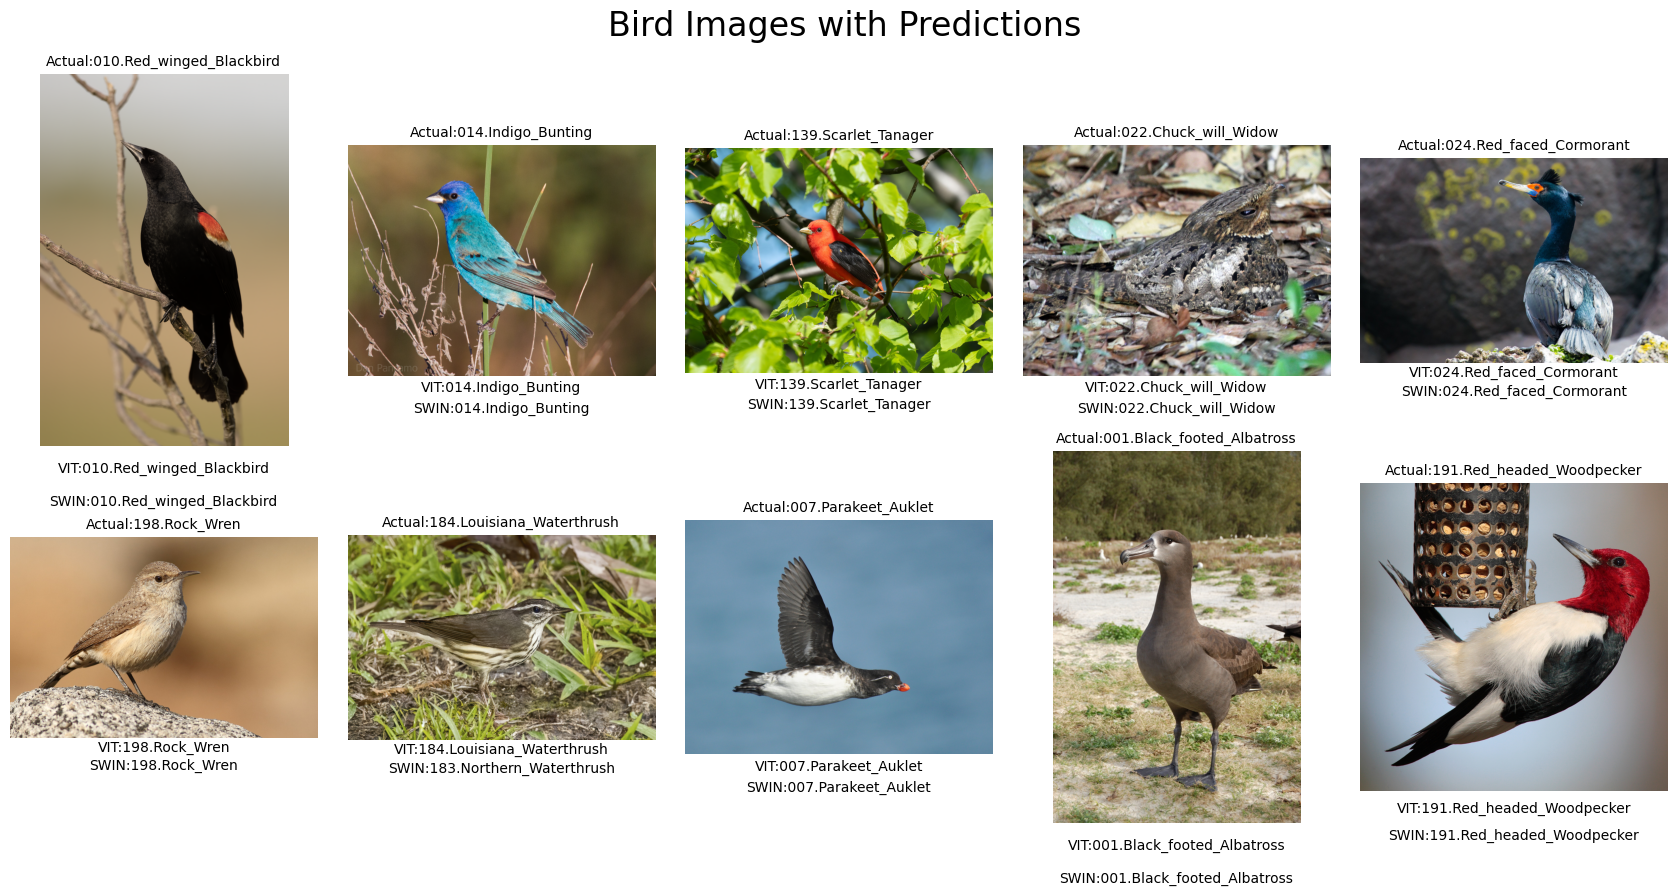

In [9]:
# Set up the grid dimensions
rows, cols = 2, 5  # Adjust based on the number of images
fig, axes = plt.subplots(rows, cols, figsize=(17, 9))

# Loop through the images and display them with filenames
for i, ax in enumerate(axes.flatten()):
    if i < len(bird_images):
        ax.imshow(bird_images[i])
        ax.axis('off')  # Hide axes
        filename_without_extension = os.path.splitext(os.listdir(bird_folder)[i])[0]
        ax.set_title(("Actual:" + model_vit.config.id2label[int(filename_without_extension)]), fontsize=10)
        ax.text(0.5, -0.07,("VIT:" + model_vit.config.id2label[preds[i]]), fontsize=10, ha="center", transform=ax.transAxes)
        ax.text(0.5, -0.16,("SWIN:" + model_swin.config.id2label[preds2[i]]), fontsize=10, ha="center", transform=ax.transAxes)
    else:
        ax.axis('off')  # Hide unused grid cells
fig.suptitle("Bird Images with Predictions", fontsize=24)

plt.tight_layout()
plt.show()

Plotted above the results are all shown and they have all worked well besides the Swin model incorrectly classifying the Lousiana Waterthrush as a Northern Waterthrush, which is not ideal but it does classify it as a very similar species of bird so it is not completely off. 

Below is showing the top 5 predictions the models (first ViT and then Swin) gave for the different images and their scores (1 would be complete confidence, 0 none at all that the image is that species of bird). I find the most interesting part is that the ViT model, which has an accuracy of 75.53% compared to the Swin model's 67.85%, is much less confidant in its final predictions than the Swin model. The highest score for an accurate prediction was .538 on the Red Faced Cormorant while Swin didn't give a score below 0.6 for an accurate prediction and it's incorrect prediction of a Northern Waterthrush was .68. 

The Swin model is much more confidant in its predictions than the ViT model despite, and presuambly connected to, its lower accuracy. 

In [10]:
for i, x in enumerate(bird_images):
    filename_without_extension = os.path.splitext(os.listdir(bird_folder)[i])[0]
    print("Bird Name: ", model_vit.config.id2label[int(filename_without_extension)])
    print("Predictions Are:", pipe_vit(x))

Bird Name:  010.Red_winged_Blackbird
Predictions Are: [{'score': 0.5087785720825195, 'label': '010.Red_winged_Blackbird'}, {'score': 0.03389113396406174, 'label': '026.Bronzed_Cowbird'}, {'score': 0.024868974462151527, 'label': '027.Shiny_Cowbird'}, {'score': 0.01070835255086422, 'label': '029.American_Crow'}, {'score': 0.01065156515687704, 'label': '012.Yellow_headed_Blackbird'}]
Bird Name:  014.Indigo_Bunting
Predictions Are: [{'score': 0.48719391226768494, 'label': '014.Indigo_Bunting'}, {'score': 0.05395509675145149, 'label': '015.Lazuli_Bunting'}, {'score': 0.05208785831928253, 'label': '054.Blue_Grosbeak'}, {'score': 0.03761541470885277, 'label': '134.Cape_Glossy_Starling'}, {'score': 0.0280575230717659, 'label': '016.Painted_Bunting'}]
Bird Name:  139.Scarlet_Tanager
Predictions Are: [{'score': 0.5868943333625793, 'label': '139.Scarlet_Tanager'}, {'score': 0.08220488578081131, 'label': '042.Vermilion_Flycatcher'}, {'score': 0.035302821546792984, 'label': '140.Summer_Tanager'}, {

In [11]:
for i, x in enumerate(bird_images):
    filename_without_extension = os.path.splitext(os.listdir(bird_folder)[i])[0]
    print("Bird Name: ", model_swin.config.id2label[int(filename_without_extension)])
    print("Predictions Are:", pipe_swin(x))

Bird Name:  010.Red_winged_Blackbird
Predictions Are: [{'score': 0.7988718152046204, 'label': '010.Red_winged_Blackbird'}, {'score': 0.03405676409602165, 'label': '024.Red_faced_Cormorant'}, {'score': 0.03109200857579708, 'label': '026.Bronzed_Cowbird'}, {'score': 0.02126505598425865, 'label': '188.Pileated_Woodpecker'}, {'score': 0.015424774028360844, 'label': '058.Pigeon_Guillemot'}]
Bird Name:  014.Indigo_Bunting
Predictions Are: [{'score': 0.7450831532478333, 'label': '014.Indigo_Bunting'}, {'score': 0.09949973225593567, 'label': '015.Lazuli_Bunting'}, {'score': 0.07125526666641235, 'label': '054.Blue_Grosbeak'}, {'score': 0.02845984324812889, 'label': '134.Cape_Glossy_Starling'}, {'score': 0.011067497543990612, 'label': '164.Cerulean_Warbler'}]
Bird Name:  139.Scarlet_Tanager
Predictions Are: [{'score': 0.8201540112495422, 'label': '139.Scarlet_Tanager'}, {'score': 0.1513020247220993, 'label': '042.Vermilion_Flycatcher'}, {'score': 0.00512284180149436, 'label': '140.Summer_Tanager

# How the Model Handles Something Random

Here is where I am loading in images that are not of birds to see what scores the model gives these (the actual final predictions will not be of much interest as there's no way for the prediction to be close to accurate).

The photos in this section were taken by me. 

In [12]:
other_images = []
other_folder = "other_images"
for filename in os.listdir(other_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Check for image files
        image = PILImage.open(os.path.join(other_folder, filename))  # Load the image
        other_images.append(image)  # Append to the list

In [13]:
encode_rand = image_preprocess(other_images) #preprocessing the image

preds_rand = []
with torch.no_grad():
    for i in range(len(encode_rand)):
        outputs_rand = model_vit(**encode_rand[i]) #getting the outputs from the model
        logits_rand = outputs_rand.logits #getting the logits
        predicted_class_idx_rand = logits_rand.argmax(-1).item() #getting the predicted class index
        preds_rand.append(predicted_class_idx_rand) #appending the predicted class index to the preds list

encode_rand2 = image_preprocess(other_images, mode = "swin") #preprocessing the image

preds_rand_swin = []
with torch.no_grad():
    for i in range(len(encode_rand)):
        outputs_rand_swin = model_swin(**encode_rand2[i]) #getting the outputs from the model
        logits_rand_swin = outputs_rand_swin.logits #getting the logits
        predicted_class_idx_rand_swin = logits_rand_swin.argmax(-1).item() #getting the predicted class index
        preds_rand_swin.append(predicted_class_idx_rand_swin) #appending the predicted class index to the preds list

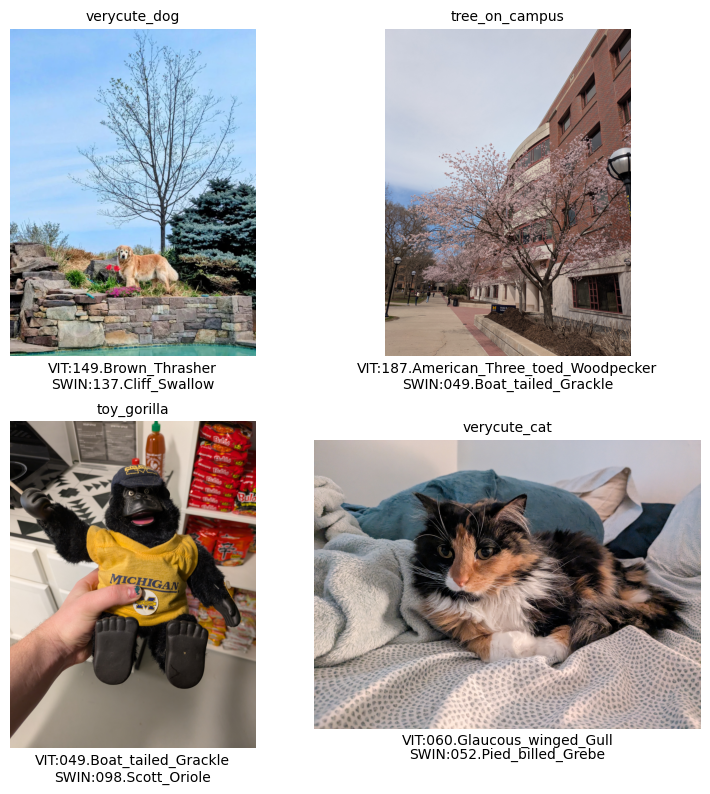

In [17]:
# Set up the grid dimensions
rows, cols = 2, 2  # Adjust based on the number of images
fig, axes = plt.subplots(rows, cols, figsize=(8, 8))

# Loop through the images and display them with filenames
for i, ax in enumerate(axes.flatten()):
    if i < len(other_images):
        ax.imshow(other_images[i])
        ax.axis('off')  # Hide axes
        # Add the filename without the extension as a title
        filename_without_extension = os.path.splitext(os.listdir(other_folder)[i])[0]
        ax.set_title(filename_without_extension, fontsize=10)
        ax.text(0.5, -0.05,("VIT:" + model_vit.config.id2label[preds_rand[i]]), fontsize=10, ha="center", transform=ax.transAxes)
        ax.text(0.5, -0.10,("SWIN:" + model_swin.config.id2label[preds_rand_swin[i]]), fontsize=10, ha="center", transform=ax.transAxes)
    else:
        ax.axis('off')  # Hide unused grid cells

plt.tight_layout()
plt.show()

Above is a photo showing the images used along with what the models predict they are. As the model is trained only on different species of birds, it is impossible for the model to have gotten any of these correct.

Of interest is below where the prediction scores are shown, first the ViT predictions and then the Swin predictions. Unsurprisngly, the models are not at all confident in any of their predictions, this range of very low scores is a reliable method of showing that the model is looking at something that it was not trained on and so could not accurately categorize. However, it is interesting to see that the top prediction scores provided by Swin on toy_gorilla and winston_the_dog have around the same confidence score as ViT assigns to its accurate prediction for the Parakeet Auklet. This again demonstrates how Swin is biased to being overly confident in its predictions. Its tendancy towards a high confidence value makes it less suitable than ViT (even ignoring the fact that it has a lower accuracy than ViT) because it would be harder to impliment a mode where it can state that it is not looking at an image it was trained to identify based on the scores it produces being uniformly low. 

In [15]:
for i,x in enumerate(other_images):
    filename_without_extension = os.path.splitext(os.listdir(other_folder)[i])[0]
    print("Other Name: ", filename_without_extension)
    print("Predictions Are:", pipe_vit(x))

Other Name:  verycute_dog
Predictions Are: [{'score': 0.028594471514225006, 'label': '149.Brown_Thrasher'}, {'score': 0.019351216033101082, 'label': '006.Least_Auklet'}, {'score': 0.015555301681160927, 'label': '120.Fox_Sparrow'}, {'score': 0.013437146320939064, 'label': '123.Henslow_Sparrow'}, {'score': 0.013376777991652489, 'label': '133.White_throated_Sparrow'}]
Other Name:  tree_on_campus
Predictions Are: [{'score': 0.018420817330479622, 'label': '187.American_Three_toed_Woodpecker'}, {'score': 0.014642414636909962, 'label': '093.Clark_Nutcracker'}, {'score': 0.014447259716689587, 'label': '021.Eastern_Towhee'}, {'score': 0.014315552078187466, 'label': '068.Ruby_throated_Hummingbird'}, {'score': 0.013305860571563244, 'label': '089.Hooded_Merganser'}]
Other Name:  toy_gorilla
Predictions Are: [{'score': 0.02255684696137905, 'label': '049.Boat_tailed_Grackle'}, {'score': 0.020288502797484398, 'label': '004.Groove_billed_Ani'}, {'score': 0.016690824180841446, 'label': '042.Vermilion_F

In [16]:
for i,x in enumerate(other_images):
    filename_without_extension = os.path.splitext(os.listdir(other_folder)[i])[0]
    print("Other Name: ", filename_without_extension)
    print("Predictions Are:", pipe_swin(x))

Other Name:  verycute_dog
Predictions Are: [{'score': 0.11920624226331711, 'label': '137.Cliff_Swallow'}, {'score': 0.09251730144023895, 'label': '195.Carolina_Wren'}, {'score': 0.0920480489730835, 'label': '034.Gray_crowned_Rosy_Finch'}, {'score': 0.04021652042865753, 'label': '198.Rock_Wren'}, {'score': 0.038794200867414474, 'label': '001.Black_footed_Albatross'}]
Other Name:  tree_on_campus
Predictions Are: [{'score': 0.04418955370783806, 'label': '049.Boat_tailed_Grackle'}, {'score': 0.02865925431251526, 'label': '030.Fish_Crow'}, {'score': 0.026627831161022186, 'label': '188.Pileated_Woodpecker'}, {'score': 0.024312462657690048, 'label': '111.Loggerhead_Shrike'}, {'score': 0.023822635412216187, 'label': '079.Belted_Kingfisher'}]
Other Name:  toy_gorilla
Predictions Are: [{'score': 0.10164301842451096, 'label': '098.Scott_Oriole'}, {'score': 0.07950932532548904, 'label': '058.Pigeon_Guillemot'}, {'score': 0.048974111676216125, 'label': '004.Groove_billed_Ani'}, {'score': 0.04647083